In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import promethee_functions as pf

# Promethee Gamma application on the HDI datasets

## 1. Read data + scaling

In [2]:
data = read_data()
data.head()
data = scale_data(data)

# Keep only 3 rows
data = data.iloc[:3]

data.head()

,iso3,co2prod,poptotal,hdi,le,gdi,eys
6,ARG,"[0.19043556311874693, 0.19708748799126294, 0.2...","[0.020942210735571794, 0.021273226668040518, 0...","[0.5945945945945946, 0.6072072072072072, 0.616...","[0.6871611693773119, 0.7007143942848458, 0.703...","[0.8944954128440368, 0.897553516819572, 0.9021...","[0.5926342789353461, 0.5900415074178023, 0.587..."
13,BGD,"[0.0, 0.00020324003233878132, 0.00039189643114...","[0.07363106531814378, 0.07511264935926601, 0.0...","[0.009009009009009018, 0.005405405405405411, 0...","[0.28702437047170287, 0.24053807569539457, 0.3...","[0.5504587155963303, 0.562691131498471, 0.5948...","[0.08428075131536233, 0.09739828033109835, 0.1..."
34,CHL,"[0.1346361578106482, 0.12376605861463034, 0.12...","[0.007298131007744375, 0.00745304905085084, 0....","[0.5603603603603603, 0.5765765765765766, 0.590...","[0.7071743426052592, 0.7325074732735471, 0.746...","[0.8348623853211011, 0.8287461773700308, 0.836...","[0.5508978220705721, 0.5501915953125217, 0.549..."


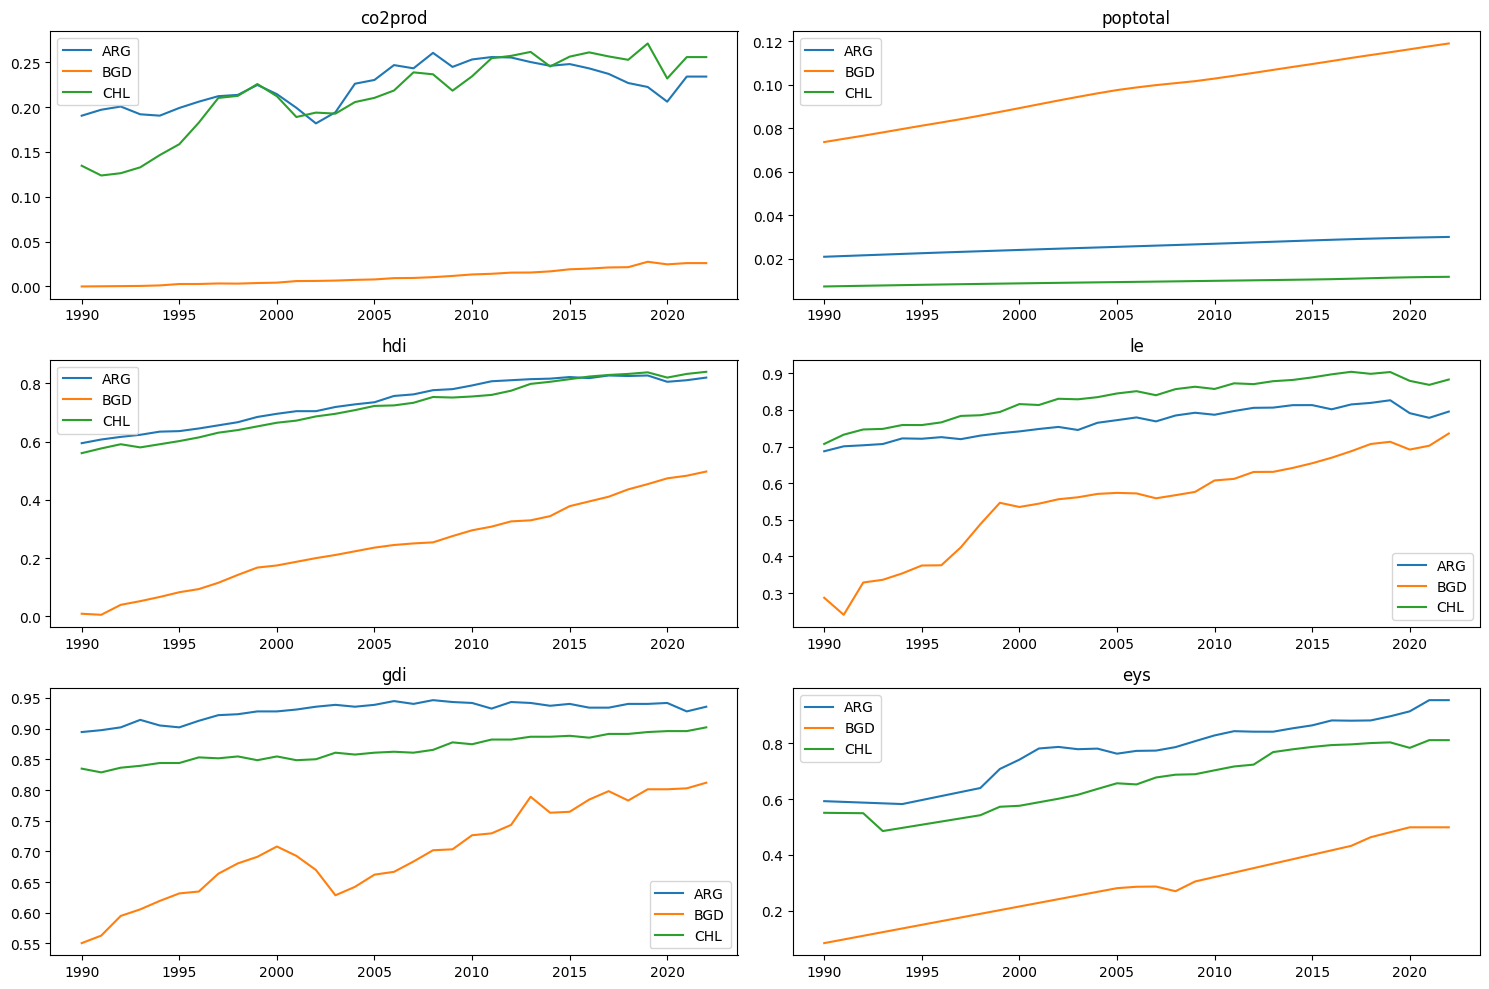

In [3]:
plot_data(data, legend=True)

## 2. Construct the Gamma matrix 
1. Create k matrices of size $n\times n$ with $P_c(a_i,a_j)$, where each element is a sequence
2. Create k lists of sequences (one per criteria): $\phi^c(a_i)$
3. Define a way to compare two alternatives for a criteria (one is better than another)
    - An idea is to take the mean of the series for example
    - Define a good metrics for this! #TODO
4. Create an $n \times n$ matrix with the values $\gamma(a_i,a_j)$ in each cell
    - Depending on the previous steps, these values will either be a list or a scalar number

In [4]:
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series
N = data.shape[0] # Number of time series
K = data.columns.shape[0] -1 # Number of features

W = [1/K for _ in range(K)]
P = [0.9 for _ in range(K)]
Q = [-0.1 for _ in range(K)]

print("L:", L)
print("N:", N)
print("K:", K)

L: 33
N: 3
K: 6


In [5]:
def linear_P_c(a_i, a_j, c):
    """ 
    Returns: The preference function within criteria c, linear version
    - a_i: a multi-criteria time series
    - a_j: a multi-criteria time series
    - c: the criteria identifier
    """
    d = a_i[c] - a_j[c]
    for i in range(len(d)): # For each time step
        if d[i] <= Q[c-1]:
            d[i] = 0
        elif d[i] > P[c-1]:
            d[i] = 1
        else:
            d[i] = (d[i] - Q[c-1]) / (P[c-1] - Q[c-1])
    return d

def P_c_matrix(data, c):
    """
    Returns: The preference matrix within criteria c, size NxN where each cell is a time series
    - data: the multi-criteria time series data
    - c: the criteria identifier
    """
    N = data.shape[0]
    P_c = np.zeros((N, N, L))
    for i in range(N):
        for j in range(N):
            if i != j:
                P_c[i][j] = linear_P_c(data.iloc[i], data.iloc[j], c+1)
    return P_c

print("P_c_matrix(data, 0).shape:", P_c_matrix(data, 0).shape)

P_c_matrix(data, 0).shape: (3, 3, 33)


C:\Users\raphu\AppData\Local\Temp\ipykernel_66568\4179098351.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


In [6]:
print("P_c_matrix(data, 0):")
print(P_c_matrix(data, 0))

P_c_matrix(data, 0):
[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.        ]
  [0.29043556 0.29688425 0.30027405 0.29141733 0.28932314 0.29634854
   0.30332738 0.3088698  0.31045737 0.3209109  0.31022647 0.29321135
   0.27567544 0.2877134  0.31875173 0.32247271 0.33760604 0.33380085
   0.35012331 0.33311967 0.33976666 0.34170241 0.33990779 0.33469874
   0.32926832 0.32886824 0.32328169 0.31585153 0.30538882 0.29492804
   0.28142237 0.30802283 0.30802283]
  [0.15579941 0.17332143 0.17436086 0.15912849 0.14398115 0.14041388
   0.12340006 0.10197877 0.10105732 0.09900132 0.10232693 0.11024326
   0.08794662 0.10150916 0.1204735  0.11998199 0.12835335 0.10450194
   0.12391787 0.1264956  0.11880382 0.10128009 0

C:\Users\raphu\AppData\Local\Temp\ipykernel_66568\4179098351.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


PHI_0.shape: (3, 33)


C:\Users\raphu\AppData\Local\Temp\ipykernel_66568\4179098351.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


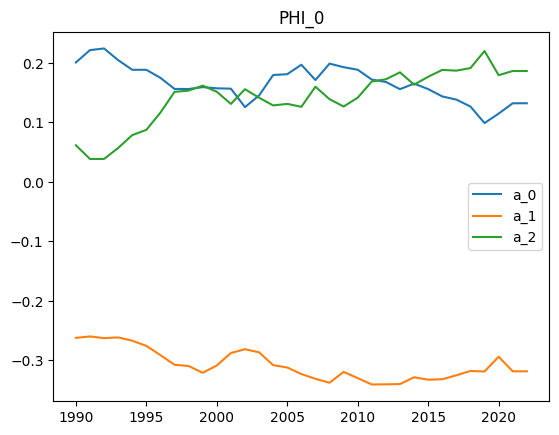

In [7]:
def get_Phi_c_ai(i, P_c):
    """
    Returns: The preference function for a_i within criteria c
    Phi_c(a_i) = 1/N-1 sum_j (P_c(a_i, a_j) - P_c(a_j, a_i))
    - a_i: a multi-criteria time series
    - P_c: the preference matrix within criteria c
    - c: the criteria identifier
    """
    N = P_c.shape[0]
    sum = 0
    for j in range(N):
        sum += P_c[i][j] - P_c[j][i] 
    return 1/(N-1) * sum


def get_Phi_c(data, c):
    """
    Returns: The preference function for all time series within criteria c
        - Phi_c is a list of size N where each cell is a time series
    - data: the multi-criteria time series data
    - c: the criteria identifier
    """
    P_c = P_c_matrix(data, c)
    N = data.shape[0]
    Phi_c = np.zeros((N, L))
    for i in range(N):
        Phi_c[i] = get_Phi_c_ai(i, P_c)
    return Phi_c




PHI_0 = get_Phi_c(data, 0)

print("PHI_0.shape:", PHI_0.shape)

def plot_Phi_c_ai(PHI_c, title):
    """
    PHI_c is a list of N time series, plot each time series in the same plot
    """
    x = np.arange(1990, 2023)
    N = PHI_c.shape[0]
    for i in range(N):
        plt.plot(x, PHI_c[i], label=f"a_{i}")
    plt.title(title)
    plt.legend()
    plt.show()

plot_Phi_c_ai(PHI_0, "PHI_0")


C:\Users\raphu\AppData\Local\Temp\ipykernel_66568\4179098351.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


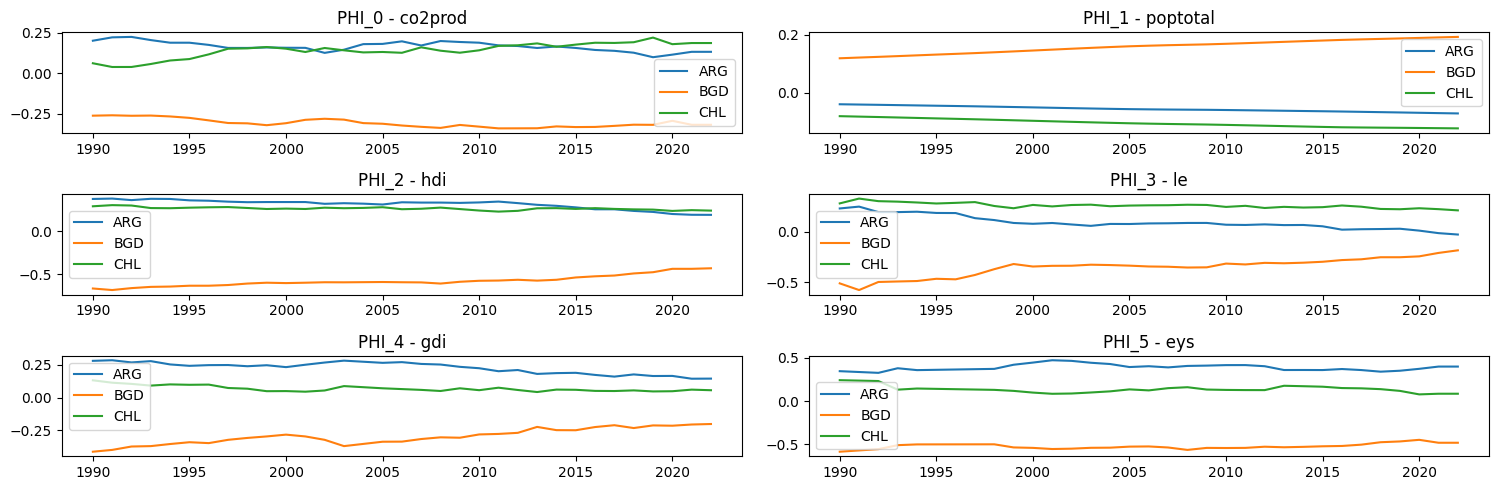

In [8]:
def get_all_Phi_c(data):
    """
    Returns: A list of all preference functions for all criteria
    """
    return [get_Phi_c(data, c) for c in range(K)]

PHI_c_all = get_all_Phi_c(data)

def plot_phi_c_all(PHI_c_all, col_names, alt_names):
    """"
    Returns subplots for each criteria
    - PHI_c_all: A list of k lists of N time series
    """
    plt.figure(figsize=(15, 5))
    x = np.arange(1990, 2023)
    for c in range(K):
        plt.subplot((K + 1) // 2, 2, c + 1)
        PHI_c = PHI_c_all[c]
        for i in range(N):
            plt.plot(x, PHI_c[i], label=alt_names[i])
        plt.title(f"PHI_{c} - {col_names[c]}")
        plt.legend()
    plt.tight_layout()

column_names = data.columns[1:]
alternative_names = data["iso3"].values

plot_phi_c_all(PHI_c_all, column_names, alternative_names)

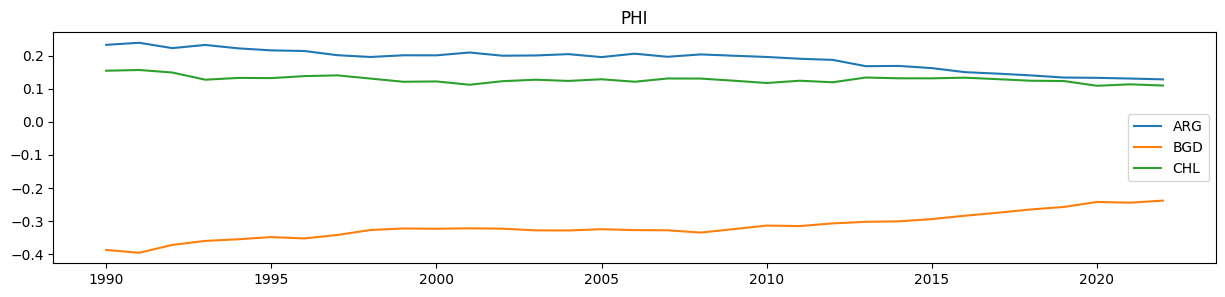

In [9]:
def PHI_all(PHI_c_all, W):
    """
    Returns: The aggregated preference function
    PHI = sum(W_c * PHI_c)
    """
    PHI = np.zeros((N, L))
    for c in range(K):
        PHI += W[c] * PHI_c_all[c]
    return PHI

PHI = PHI_all(PHI_c_all, W)

def plot_PHI(PHI, alt_names):
    """
    Plot the aggregated preference function
    """
    x = np.arange(1990, 2023)
    plt.figure(figsize=(15, 3))
    for i in range(N):
        plt.plot(x, PHI[i], label=alt_names[i])
    plt.title("PHI")
    plt.legend()
    plt.show()

plot_PHI(PHI, alternative_names)

# 3. Test on whole dataset


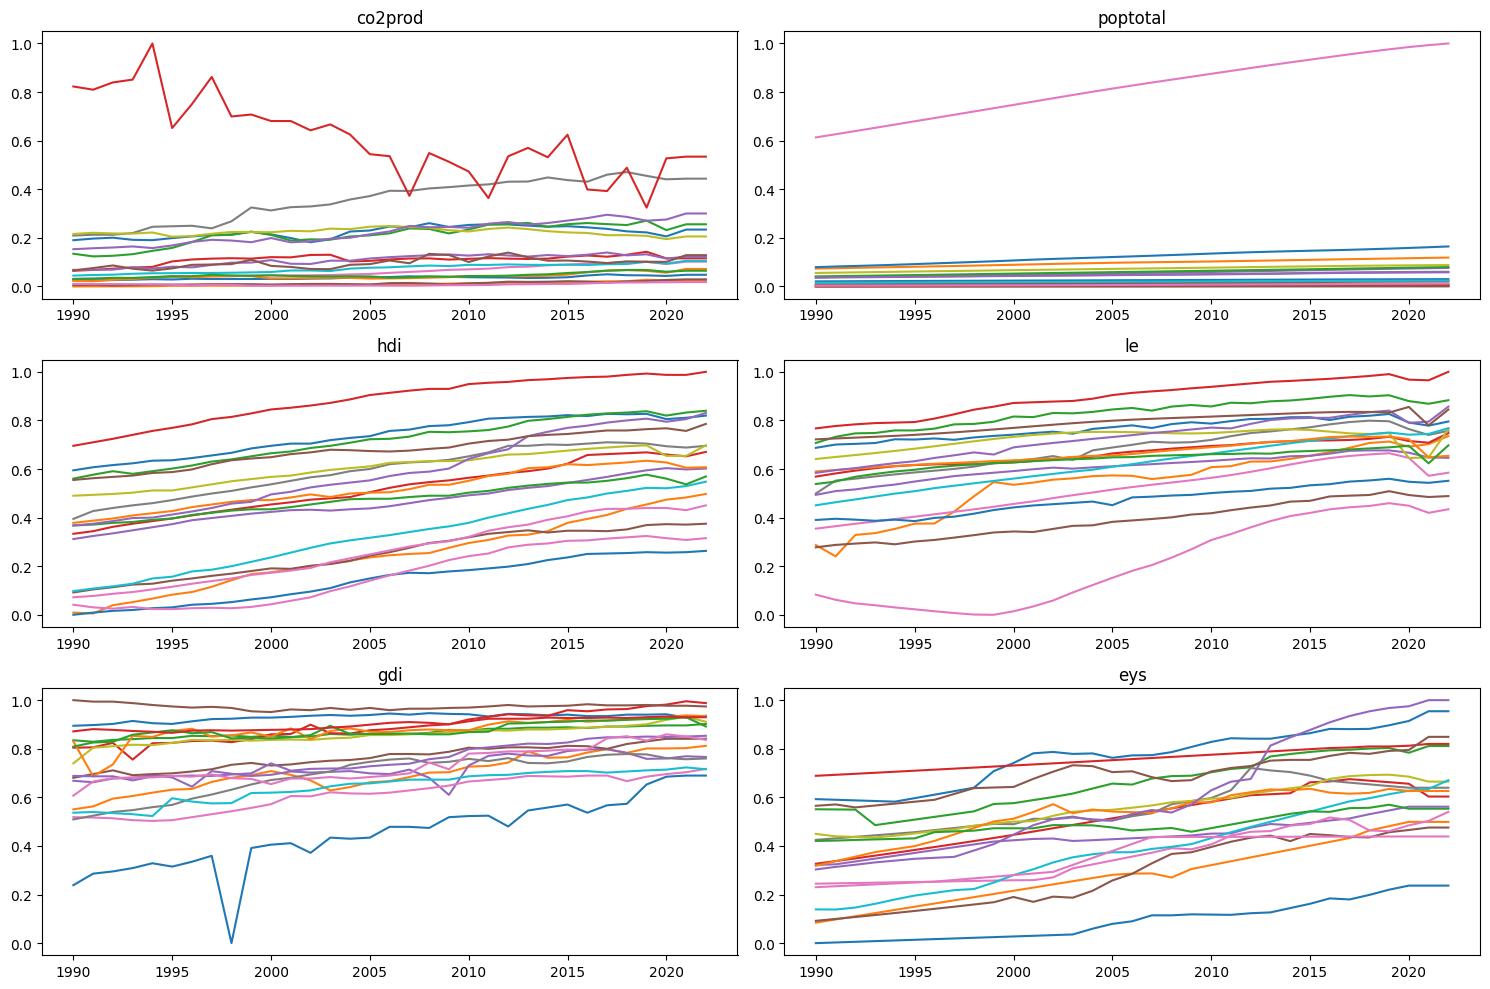

c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\promethee_functions.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


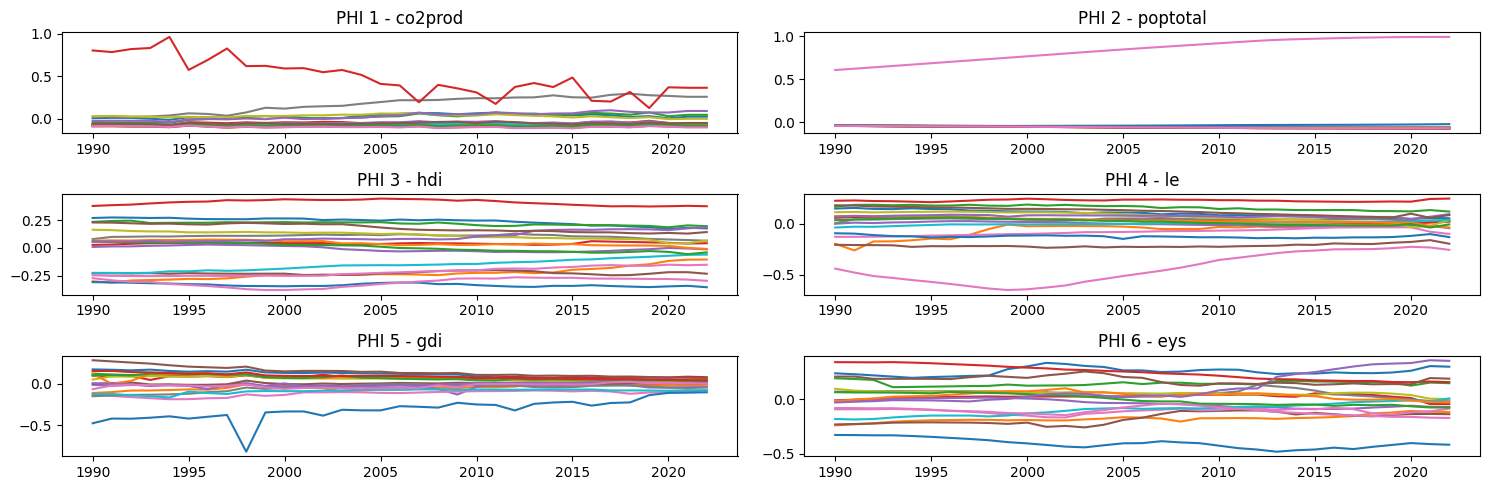

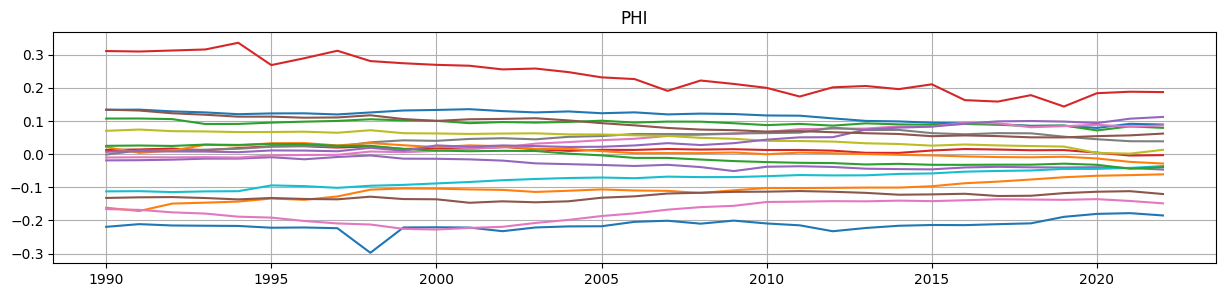

In [10]:
pf.main()